In [3]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("src") # go to parent dir
from detect import *
from reproject import *
import rosbag
from sklearn.metrics import mean_squared_error
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import cv2

rospy.init_node("sd_jupyter")

[[1.37544824e+03 0.00000000e+00 9.50562012e+02]
 [0.00000000e+00 1.37584045e+03 5.66901917e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [5]:
import tensorrt as trt
import torch2trt

logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, '')


@torch2trt.tensorrt_converter('torch.nn.functional.leaky_relu')
def convert_leaky_relu(ctx):
    input = ctx.method_args[0]
    output = ctx.method_return
    
    if len(ctx.method_args) > 1:
        negative_slope = ctx.method_args[1]
    elif 'negative_slope' in ctx.method_kwargs:
        negative_slope = ctx.method_kwargs['negative_slope']
    
    registry = trt.get_plugin_registry()
    
    creator = [c for c in registry.plugin_creator_list if c.name == 'LReLU_TRT'][0]
    lrelu_slope_field = trt.PluginField("neg_slope", np.array([negative_slope], dtype=np.float32), trt.PluginFieldType.FLOAT32)
    field_collection = trt.PluginFieldCollection([lrelu_slope_field])
    plugin = creator.create_plugin(name='LReLU_TRT', field_collection=field_collection)
            
    layer = ctx.network.add_plugin_v2(inputs=[input._trt], plugin=plugin)
                                  
    output._trt = layer.get_output(0)



In [7]:
#bag = rosbag.Bag("/home/xuhao/bags/dl_data/swarm_dl_one_ground_2019-08-18-05-52-01.bag")
#bag = rosbag.Bag("/home/xuhao/bags/swarm_one_drone_reproject_2019-08-18-15-37-47.bag")
#bag = rosbag.Bag("/home/xuhao/bags/dl_data/swarm_dl_2drone_fly_2019-08-17-12-42-29.bag")
bag = rosbag.Bag("/media/xuhao/Swarm/swarm_bags/swarm_dl_2drone_fly_2019-08-17-12-42-29.orig.bag")
#bag = rosbag.Bag("/home/xuhao/bags/dl_data/swarm_dl_four_drones_2019-08-14-07-49-37.bag")
poses, camera, depths = read_bag(bag)
#dp2 = parse_ros_pose_ts(poses[2])
#dp4 = parse_ros_pose_ts(poses[4])

In [8]:
### index = 100
sd = SwarmDetector(debug_show="cv",conf_thres=0.9)
step = 1
err = []
est_3d_poses = []

gt_3d_poses = []

start_index = 0
for index in range(start_index, len(camera), step):
#     print(index - start_index)
    t_cam_on_drone = np.array([0.044, -0.035, 0.0])
    R_cam_on_drone = np.array([[0, 0, 1],
             [-1, 0, 0],
             [0, -1, 0]])
    
    img_msg = camera[index]
    _img  = sd.img_callback(img_msg, depths[index])
    _img = cv2.resize(_img, (1280, 960))
    cv2.putText(_img, "FRAME {}".format(index - start_index), (100, 40), cv2.FONT_HERSHEY_SIMPLEX,1, (200, 200, 200), 1, cv2.LINE_AA)
    cv2.imshow("YOLO", _img)
    k = cv2.waitKey(10)
    if k == ord('q'):
        break
    continue
    
    
    if dposyolo_camframe is None:
        continue
    dposyolo_camframe =  dposyolo_camframe
    pos4 = dp4["pos_func"](img_msg.header.stamp.to_sec()) + np.array([0.053, -0.05, -0.075])
    quat4 = dp4["quat_func"](img_msg.header.stamp.to_sec())
    quat2 = dp2["quat_func"](img_msg.header.stamp.to_sec())
    pos2 = dp2["pos_func"](img_msg.header.stamp.to_sec()) + t_cam_on_drone
    dpos_gt = pos4 - pos2 

    r2 = quaternion_matrix(quat2)[0:3,0:3]
    r2cam = np.dot(r2, R_cam_on_drone)
    dposyolo_global = np.dot(r2cam, dposyolo_camframe)
    dyolo_gt = dposyolo_global - dpos_gt
    if math.fabs(dyolo_gt[0]) > 0.5 or math.fabs(dyolo_gt[1]) > 0.5 or math.fabs(dyolo_gt[2] > 0.5):
        continue
    err.append(dposyolo_global - dpos_gt)
    est_3d_poses.append(dposyolo_global + pos2)
    
    

cv2.destroyAllWindows()
err = numpy.array(err)

[INFO] [1566411535.840841]: CONVERTING MODEL to trt
[INFO] [1566411548.696180]: Finish converion
[INFO] [1566411549.327265]: Detection use time 13564.502001ms
[INFO] [1566411549.539889]: Total use time 13899.070024ms
[INFO] [1566411550.330056]: Detection use time 5.859852ms
[INFO] [1566411550.558832]: Total use time 10.142088ms
[INFO] [1566411551.356588]: Detection use time 5.028009ms
[INFO] [1566411551.582692]: Total use time 9.981871ms
[INFO] [1566411552.380898]: Detection use time 4.131079ms
[INFO] [1566411552.604133]: Total use time 12.871981ms
TRACKER 825 failed
[INFO] [1566411553.396963]: Detection use time 4.580021ms
[INFO] [1566411553.619036]: Total use time 6.801128ms
[INFO] [1566411554.407556]: Detection use time 4.787922ms
[INFO] [1566411554.629669]: Total use time 7.012129ms
[INFO] [1566411555.423907]: Detection use time 4.682064ms
[INFO] [1566411555.637172]: Total use time 7.409811ms
[INFO] [1566411556.442097]: Detection use time 4.744053ms
[INFO] [1566411556.639384]: Tota

IndexError: list index out of range

In [6]:
('DTS ', torch.Size([1, 2535, 6]))
torch.Size([1, 18, 13, 13])
torch.Size([1, 18, 26, 26])

torch.Size([1, 18, 26, 26])

IndexError: too many indices for array

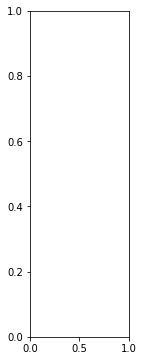

In [71]:
err = np.array(err)
est_3d_poses = np.array(est_3d_poses )
plt.figure(100, figsize=(6, 6))
plt.subplot(131)
plt.hist(est_3d_poses[:,0] - np.mean(est_3d_poses[:,0]), density=True, bins=30)
plt.xlabel("EST X")
plt.grid()

plt.subplot(132)
plt.hist(est_3d_poses[:,1] - np.mean(est_3d_poses[:,1]), density=True, bins=30)
plt.xlabel("EST Y")
plt.grid()

plt.subplot(133)
plt.hist(est_3d_poses[:,2] - np.mean(est_3d_poses[:,2]), density=True, bins=30)
plt.xlabel("EST Z")
plt.grid()
plt.show()


print("XYZ MEAN {:3.1f} {:3.1f} {:3.1f} cm RMSE {:3.1f} {:3.1f} {:3.1f}cm".format(
    np.mean(err[:,0])*100, 
    np.mean(err[:,1])*100, 
    np.mean(err[:,2])*100,
    np.sqrt(np.mean((err[:,0])**2))*100,
    np.sqrt(np.mean((err[:,1])**2))*100,
    np.sqrt(np.mean((err[:,2])**2))*100))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(est_3d_poses[:,0], est_3d_poses[:,1], est_3d_poses[:,2], marker="^")
#[ 1.16626224, -0.21409655,  0.52796817]
ax.set_xlim3d(0.5, 1.5)
ax.set_ylim3d(-0.5, 0.)
ax.set_zlim3d(0, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


In [6]:
cv2.destroyAllWindows()